## Extras

# Parameter optimization using gensim

This notebook contains some experimentation using the topic coherence that is available out-of-the-box in `gensim`'s implementation of Latent Dirichlet Allocation.

In these experiments, we follow and adapt the code of two tutorials:
- [One on performing topic modeling using gensim](https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21).
- [Another one on topic coherence in gensim](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0).

##  Importing our corpus

As in other notebooks, we start by importing our corpus:

In [1]:
import json
import re
import os
import sys 

# Jupyter Notebooks are not good at handling relative imports.
# Best solution (not great practice) is to add the project's path
# to the module loading paths of sys.

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.loaders import loadCorpusList, saveCorpus

corpusPath = '../data/corpus'

corpusList = loadCorpusList(corpusPath)
corpusList = [a for a in corpusList if a.lang == "es"]

For `gensim`, we will need to provide the bag-of-words as a list of strings. Thus, we start by implementing a generic function that takes objects of our article class and returns the list representation of its bag of words. It includes a hot fix to a problem we are facing in the generation of the bag of words: there are several spaces that make `bagOfWords.split(" ")` contain empty strings.

In [2]:
def prepare_bag_of_words(article):
    """
    A hot fix on some empty strings.
    """
    bow = article.bagOfWords
    bow = bow.split(" ")
    return [w for w in bow if len(w) > 1]

## Creating a dictionary and a corpus for `gensim`

In [3]:
from gensim import corpora

In [4]:
dictionary = corpora.Dictionary([
    prepare_bag_of_words(a) for a in corpusList
])

In [5]:
corpus = [dictionary.doc2bow(prepare_bag_of_words(a)) for a in corpusList]

TODO: save `dictionary` and `corpus` using pickle.

## Fitting an LDA using gensim

In [6]:
from gensim.models.ldamodel import LdaModel

In [7]:
n_topics = 10
lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=15)

In [8]:
topics = lda.print_topics(num_words=10)
for topicNum, topic in topics:
    print(f"Topic #{topicNum}: ", topic)

Topic #0:  0.006*"idea" + 0.005*"filosofía" + 0.003*"mundo" + 0.003*"deber" + 0.003*"forma" + 0.003*"bien" + 0.003*"valorar" + 0.003*"filosófico" + 0.003*"ciencia" + 0.003*"hombre"
Topic #1:  0.023*"kant" + 0.009*"ser" + 0.008*"razón" + 0.008*"moral" + 0.006*"juicio" + 0.006*"libertar" + 0.005*"naturaleza" + 0.005*"ley" + 0.005*"concepto" + 0.004*"bien"
Topic #2:  0.015*"ser" + 0.007*"mundo" + 0.006*"objeto" + 0.005*"experiencia" + 0.005*"concepto" + 0.005*"filosofía" + 0.005*"heidegger" + 0.005*"conciencia" + 0.004*"hegel" + 0.004*"modo"
Topic #3:  0.012*"nietzsche" + 0.007*"ser" + 0.006*"hermenéutico" + 0.005*"heidegger" + 0.004*"rorty" + 0.004*"modo" + 0.004*"filosofía" + 0.003*"husserl" + 0.003*"texto" + 0.003*"vida"
Topic #4:  0.009*"ser" + 0.004*"caso" + 0.004*"moral" + 0.004*"sentimiento" + 0.004*"ley" + 0.004*"mundo" + 0.004*"propiedad" + 0.004*"hume" + 0.004*"objeto" + 0.004*"bien"
Topic #5:  0.006*"dios" + 0.006*"voluntad" + 0.004*"hombre" + 0.004*"ser" + 0.004*"quod" + 0.004

## Visualizing an LDA using pyLDAvis

One of the advantages of using `gensim` is `pyLDAvis`, a visualization utility that takes `gensim`'s objects (the `lda` model, the `corpus` and the `dictionary` we created above) and creates a visualization of the `lda`'s latent space and topic representation:

In [9]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

## Topic coherence using gensim

`gensim` itself brings a `CoherenceModel` object that measures a metric of coherence which can be used to assess and evaluate an LDA model.

In [10]:
from gensim.models import CoherenceModel

In [11]:
texts = [
    prepare_bag_of_words(a) for a in corpusList
]

In [12]:
coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.34866128422174336


This coherence score allows us to do a search for the "best" `n_topics`. Let's print the coherence doing a normal search between 10 and 150 topics. Notice that this coherence score is sensitive to the random number generation that is used when creating the `lda`.

In [13]:
coherence_per_topics = {}
for n_topics in range(10, 151, 5):
    lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=15)
    coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    c = coherence_model_lda.get_coherence()
    coherence_per_topics[n_topics] = c
    print(f'Topics: {n_topics}. Coherence Score: {c}')

Topics: 10. Coherence Score: 0.37710615494385047
Topics: 15. Coherence Score: 0.36632421166730844
Topics: 20. Coherence Score: 0.3604937177292632
Topics: 25. Coherence Score: 0.3427902730729268
Topics: 30. Coherence Score: 0.39809948955337876
Topics: 35. Coherence Score: 0.39363688808960084
Topics: 40. Coherence Score: 0.3655473608817721
Topics: 45. Coherence Score: 0.38006779341649205
Topics: 50. Coherence Score: 0.39809262258502687
Topics: 55. Coherence Score: 0.3976247657868142
Topics: 60. Coherence Score: 0.39838512533585874
Topics: 65. Coherence Score: 0.38925167706344843
Topics: 70. Coherence Score: 0.38412124371777184
Topics: 75. Coherence Score: 0.3838521735474281
Topics: 80. Coherence Score: 0.36476350197899093
Topics: 85. Coherence Score: 0.4048923976432595
Topics: 90. Coherence Score: 0.4170643119091725
Topics: 95. Coherence Score: 0.407836509863743
Topics: 100. Coherence Score: 0.3969920410791532
Topics: 105. Coherence Score: 0.3941862721605905
Topics: 110. Coherence Score:

{10: 0.37710615494385047,
 15: 0.36632421166730844,
 20: 0.3604937177292632,
 25: 0.3427902730729268,
 30: 0.39809948955337876,
 35: 0.39363688808960084,
 40: 0.3655473608817721,
 45: 0.38006779341649205,
 50: 0.39809262258502687,
 55: 0.3976247657868142,
 60: 0.39838512533585874,
 65: 0.38925167706344843,
 70: 0.38412124371777184,
 75: 0.3838521735474281,
 80: 0.36476350197899093,
 85: 0.4048923976432595,
 90: 0.4170643119091725,
 95: 0.407836509863743,
 100: 0.3969920410791532,
 105: 0.3941862721605905,
 110: 0.421873729986542,
 115: 0.4089201931349832,
 120: 0.4120886963582224,
 125: 0.4173172213893256,
 130: 0.4041620310917993,
 135: 0.4014295404079761,
 140: 0.41600626086828374,
 145: 0.4035314877979475,
 150: 0.40856796279320434}

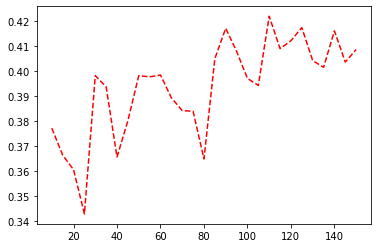

In [15]:
coherence_per_topics

In [16]:
import numpy as np
import matplotlib.pyplot as plt

x = list(coherence_per_topics.keys())
y = [coherence_per_topics[n] for n in x]

plt.plot(x, y, "--r")

**TODO**: use some statistics to analyze, and include other hyperparameters in the search.

In [39]:
from operator import itemgetter

tuples = list(coherence_per_topics.items())
tuples.sort(key=itemgetter(1), reverse=True)

In [40]:
tuples

[(140, 0.42246185828953164),
 (125, 0.4224232262669186),
 (150, 0.4224099020052343),
 (120, 0.41990234929075476),
 (115, 0.41452737337795525),
 (105, 0.4144724909777743),
 (110, 0.41064641741297353),
 (95, 0.4100913087477525),
 (145, 0.4048387086672429),
 (85, 0.40138230384567275),
 (60, 0.40132935429954597),
 (80, 0.39682867183171533),
 (55, 0.3930596131893205),
 (130, 0.3898254800212656),
 (50, 0.38853021299767915),
 (135, 0.3883369162886785),
 (70, 0.3882585618068807),
 (90, 0.38472102679797954),
 (65, 0.3805043842582022),
 (100, 0.3801665148496333),
 (75, 0.3800360037294171),
 (40, 0.3654173467844408),
 (45, 0.35818268356111255),
 (10, 0.3529584097627566),
 (25, 0.3435222242397539),
 (15, 0.3384085599446584),
 (35, 0.3379262882371989),
 (20, 0.33025337914520897),
 (30, 0.3284817585586472)]

Even though the results are noisy, the optima seems to be somewhere above 100.